In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from collections import defaultdict
%matplotlib inline

In [2]:
glob.glob("data/*csv")

['data/height_UK_WHO_preterm.csv',
 'data/weight_british_1990.csv',
 'data/height_british_1990.csv',
 'data/weight_UK_WHO_preterm.csv',
 'data/ofc_british_1990.csv',
 'data/bmi_british_1990.csv',
 'data/ofc_UK_WHO_preterm.csv']

In [3]:
measurements = defaultdict(dict)
for dataset in ['british_1990', 'UK_WHO_preterm']:
    for csv in glob.glob("data/*{}.csv".format(dataset)):
        msr = os.path.basename(csv).replace('_' + dataset + '.csv', '')
        measurements[dataset][msr] = pd.read_csv(csv, sep='\t')
        measurements[dataset][msr]['Gender'] = measurements[dataset][msr]['Gender'].apply(
            lambda x: 'male' if x == 1 else 'female')


In [4]:
measurements['british_1990']['height']

,Age,L,M,S,Gender
0,-0.134,1,45.05,0.04139,male
1,-0.115,1,45.91,0.04107,male
2,-0.096,1,46.76,0.04075,male
3,-0.077,1,47.62,0.04042,male
4,-0.057,1,48.48,0.04010,male
...,...,...,...,...,...
563,22.667,1,163.80,0.03681,female
564,22.750,1,163.80,0.03681,female
565,22.833,1,163.81,0.03681,female
566,22.917,1,163.82,0.03680,female


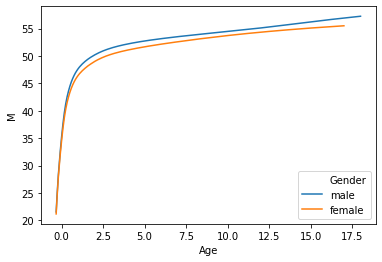

In [5]:
sns.lineplot(data=measurements['british_1990']['ofc'], hue='Gender', x='Age', y='M')

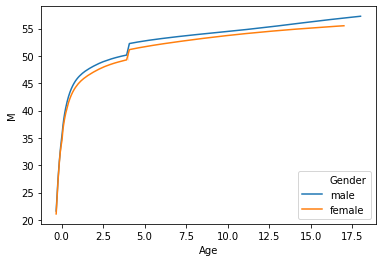

In [6]:
sns.lineplot(data=measurements['UK_WHO_preterm']['ofc'], hue='Gender', x='Age', y='M')

In [141]:
unit_converter = {'days':   lambda x: x/365.25,
                  'weeks':  lambda x: x/52.1429,
                  'months': lambda x: x/12,
                  'years':  lambda x: x,
                 }

def adjust_age(years, weeks_gestation, verbose=False):
    if weeks_gestation < 40:
        adjust = unit_converter['weeks'](40 - weeks_gestation)
        if verbose:
            print("Adjusting age by {} for {} weeks gestation".format(
                    adjust, weeks_gestation))
        years -= adjust
    return years
    

def calculate_zscore(measure, x, gender, age, weeks_gestation=40,
                     dataset='british_1990',
                     age_unit='years', return_nearest_age=False, verbose=False):
    age = unit_converter[age_unit](age)
    age = adjust_age(age, weeks_gestation, verbose=verbose)
    gender = gender.lower()
    df = measurements[dataset][measure]
    row = df.iloc[np.abs(df[df.Gender == gender].Age - age).idxmin()]
    z = (( x / row.M)**row.L - 1) / (row.S * row.L)
    if verbose:
        print("Using nearest age of {} for user provided age of {}".format(row.Age, age))
        print("Using {} dataset".format(dataset))
        print("Z-score for {} years old {} {} of {} = {}".format(age, gender, measure, x, z))
    if return_nearest_age:
        return z, row.Age, age
    return z

def zscore_cohort(individuals, dataset='british_1990', default_age_unit='years'):
    col_order = ['ID', 'weight', 'weight SD', 'ofc', 'ofc SD', 'height', 'height SD',
                 'Gender', 'Provided_Age', 
                 'Provided_Age_Unit', 'Gestation', 'Age', 'Adjusted_age',
                 'Nearest_age_weight', 'Nearest_age_ofc', 'Nearest_age_height']
    results = defaultdict(list)
    for i in range(len(individuals)):
        for req in ['id', 'gender', 'age',]:
            if req not in individuals[i]:
                raise ValueError("Required field '{}' not available for individual {}".format(req, i))
        age_unit = individuals[i].get('age_unit', default_age_unit)
        years = unit_converter[age_unit](individuals[i]['age'])
        results['ID'].append(individuals[i]['id'])
        results['Provided_Age'].append(individuals[i]['age'])
        results['Provided_Age_Unit'].append(age_unit)
        results['Age'].append(years)
        results['Adjusted_age'].append(adjust_age(years, individuals[i].get('gestation', 40)))
        results['Gender'].append(individuals[i]['gender'])
        results['Gestation'].append(individuals[i].get('gestation', 40))
        for m in ['weight', 'ofc', 'height']:
            z, n, adj = None, None, unit_converter[age_unit](individuals[i]['age'])
            if m in individuals[i]:
                z, n, adj = calculate_zscore(measure=m,
                                             x=individuals[i][m], 
                                             gender=individuals[i]['gender'],
                                             weeks_gestation=individuals[i].get('gestation', 40),
                                             age=individuals[i]['age'], 
                                             age_unit=age_unit,
                                             dataset=dataset,
                                             return_nearest_age=True)
            results[m].append(individuals[i].get(m, None))
            results[m + " SD"].append(z)
            results['Nearest_age_{}'.format(m)].append(n)
    df = pd.DataFrame.from_dict(results)
    df = df[col_order]
    return df

In [143]:
calculate_zscore('weight', 0.926, 'Male', -9, age_unit='weeks', dataset='british_1990', verbose=True)
calculate_zscore('height', 35, 'Male', -6, age_unit='weeks', dataset='british_1990', verbose=True)
calculate_zscore('ofc', 26.6, 'Male', -9, age_unit='weeks', dataset='british_1990', verbose=True)

Using nearest age of -0.172 for user provided age of -0.17260259786087848
Using british_1990 dataset
Z-score for -0.17260259786087848 years old male weight of 0.926 = -2.756615443874826
Using nearest age of -0.115 for user provided age of -0.11506839857391898
Using british_1990 dataset
Z-score for -0.11506839857391898 years old male height of 35 = -5.7861908603959735
Using nearest age of -0.172 for user provided age of -0.17260259786087848
Using british_1990 dataset
Z-score for -0.17260259786087848 years old male ofc of 26.6 = -2.0110952355304574


-2.0110952355304574

In [144]:
calculate_zscore('weight', 0.926, 'Male', 0, age_unit='weeks', weeks_gestation=31,
                 dataset='british_1990', verbose=True)
calculate_zscore('height', 35, 'Male', 3, age_unit='weeks', weeks_gestation=31,
                 dataset='british_1990', verbose=True)
calculate_zscore('ofc', 26.6, 'Male', 0, age_unit='weeks', weeks_gestation=31,
                 dataset='british_1990', verbose=True)

Adjusting age by 0.17260259786087848 for 31 weeks gestation
Using nearest age of -0.172 for user provided age of -0.17260259786087848
Using british_1990 dataset
Z-score for -0.17260259786087848 years old male weight of 0.926 = -2.756615443874826
Adjusting age by 0.17260259786087848 for 31 weeks gestation
Using nearest age of -0.115 for user provided age of -0.11506839857391898
Using british_1990 dataset
Z-score for -0.11506839857391898 years old male height of 35 = -5.7861908603959735
Adjusting age by 0.17260259786087848 for 31 weeks gestation
Using nearest age of -0.172 for user provided age of -0.17260259786087848
Using british_1990 dataset
Z-score for -0.17260259786087848 years old male ofc of 26.6 = -2.0110952355304574


-2.0110952355304574

In [128]:
calculate_zscore('weight', 18.25, 'Male', 18, dataset='british_1990', verbose=True)
calculate_zscore('height', 109.9, 'Male', 18, dataset='british_1990', verbose=True)
calculate_zscore('ofc', 48.5, 'Male', 18, dataset='british_1990', verbose=True)

Using nearest age of 18.0 for user provided age of 18
Using british_1990 dataset
Z-score for 18 years old male weight of 18.25 = -14.239794954580626
Using nearest age of 18.0 for user provided age of 18
Using british_1990 dataset
Z-score for 18 years old male height of 109.9 = -9.585942360337782
Using nearest age of 18.0 for user provided age of 18
Using british_1990 dataset
Z-score for 18 years old male ofc of 48.5 = -5.11489060264972


-5.11489060264972

In [129]:
calculate_zscore('weight', 0.74, 'Female', -10, age_unit='weeks',dataset='british_1990', verbose=True)
calculate_zscore('ofc', 25, 'Female', -10, age_unit='weeks',dataset='british_1990', verbose=True)
calculate_zscore('height', 34, 'Female', -10, age_unit='weeks',dataset='british_1990', verbose=True)


Using nearest age of -0.192 for user provided age of -0.19178066428986498
Using british_1990 dataset
Z-score for -0.19178066428986498 years old female weight of 0.74 = -2.905970228315133
Using nearest age of -0.192 for user provided age of -0.19178066428986498
Using british_1990 dataset
Z-score for -0.19178066428986498 years old female ofc of 25 = -2.3194760547990287
Using nearest age of -0.134 for user provided age of -0.19178066428986498
Using british_1990 dataset
Z-score for -0.19178066428986498 years old female height of 34 = -6.047048788230979


-6.047048788230979

In [130]:
calculate_zscore('weight', 0.74, 'Female', -10, age_unit='weeks',dataset='UK_WHO_preterm', verbose=True)
calculate_zscore('ofc', 25, 'Female', -10, age_unit='weeks',dataset='UK_WHO_preterm', verbose=True)
calculate_zscore('height', 34, 'Female', -10, age_unit='weeks',dataset='UK_WHO_preterm', verbose=True)

Using nearest age of -0.191649555099247 for user provided age of -0.19178066428986498
Using UK_WHO_preterm dataset
Z-score for -0.19178066428986498 years old female weight of 0.74 = -2.3798957699137215
Using nearest age of -0.191649555099247 for user provided age of -0.19178066428986498
Using UK_WHO_preterm dataset
Z-score for -0.19178066428986498 years old female ofc of 25 = -2.0575018824447757
Using nearest age of -0.191649555099247 for user provided age of -0.19178066428986498
Using UK_WHO_preterm dataset
Z-score for -0.19178066428986498 years old female height of 34 = -2.337822449368135


-2.337822449368135

In [131]:
calculate_zscore('weight', 1.88, 'Female', 8, age_unit='weeks', dataset='british_1990', verbose=True)
calculate_zscore('ofc', 30, 'Female', 8, age_unit='weeks', dataset='british_1990', verbose=True)
calculate_zscore('height', 40, 'Female', 8, age_unit='weeks', dataset='british_1990', verbose=True)

Using nearest age of 0.16699999999999998 for user provided age of 0.15342453143189197
Using british_1990 dataset
Z-score for 0.15342453143189197 years old female weight of 1.88 = -6.819787110350214
Using nearest age of 0.16699999999999998 for user provided age of 0.15342453143189197
Using british_1990 dataset
Z-score for 0.15342453143189197 years old female ofc of 30 = -7.41293629546379
Using nearest age of 0.16699999999999998 for user provided age of 0.15342453143189197
Using british_1990 dataset
Z-score for 0.15342453143189197 years old female height of 40 = -8.494449070930305


-8.494449070930305

In [132]:
calculate_zscore('weight', 3.78, 'Male', 1.9, age_unit='years', dataset='british_1990', verbose=True)
calculate_zscore('ofc', 43.5, 'Male', 1.9, age_unit='years', dataset='british_1990', verbose=True)
calculate_zscore('height', 55.7, 'Male', 1.9, age_unit='years', dataset='british_1990', verbose=True)

Using nearest age of 1.9169999999999998 for user provided age of 1.9
Using british_1990 dataset
Z-score for 1.9 years old male weight of 3.78 = -11.903961277209484
Using nearest age of 1.9169999999999998 for user provided age of 1.9
Using british_1990 dataset
Z-score for 1.9 years old male ofc of 43.5 = -5.032630312962828
Using nearest age of 1.9169999999999998 for user provided age of 1.9
Using british_1990 dataset
Z-score for 1.9 years old male height of 55.7 = -9.97103729371841


-9.97103729371841

In [153]:
prim1_prenatal = [dict(id=2099, gender='female', gestation=30, 
                       age=0, weight=0.74, ofc=25, height=34,),
                  dict(id=1802, gender='male', gestation=35,
                       age=0, weight=0.99, ofc=28, height=38,),
                  dict(id=2331, gender='male', gestation=38,
                       age=0, weight=1.64, ofc=29, height=40.5,),
                  dict(id=1904, gender='female', gestation=38,
                       age=0, weight=1.48, ofc=32, height=40,),
                  dict(id=281376, gender='male', gestation=38,
                       age=0, weight=1.956, ),
                 ]
prim1_postnatal = [
                   dict(id=2099, gender='female', gestation=30,
                        age=4.5, age_unit='months', weight=1.88, ofc=30, height=40,),
                   dict(id=1802, gender='male', gestation=35,
                        age=9, age_unit='months', weight=3.00, ofc=38, height=55,),
                   dict(id=2331, gender='female', gestation=38,
                        age=16, age_unit='months', weight=2.74, ofc=41, height=54,),
                   dict(id=1904, gender='male', gestation=38,
                        age=5, age_unit='years', weight=6.095, ofc=41, height=71,),
                   dict(id=281376, gender='male', gestation=38,
                        age=2.03, weight=3.78, ofc=43.5, height=55.7),
                  ]
zscore_cohort(prim1_prenatal)

,ID,weight,weight SD,ofc,ofc SD,height,height SD,Gender,Provided_Age,Provided_Age_Unit,Gestation,Age,Adjusted_age,Nearest_age_weight,Nearest_age_ofc,Nearest_age_height
0,2099,0.740,-2.905970,25.0,-2.319476,34.0,-6.047049,female,0,years,30,0,-0.191781,-0.192,-0.192,-0.134
1,1802,0.990,-4.190948,28.0,-3.150480,38.0,-4.597291,male,0,years,35,0,-0.095890,-0.096,-0.096,-0.096
2,2331,1.640,-3.550393,29.0,-3.898471,40.5,-4.503896,male,0,years,38,0,-0.038356,-0.038,-0.038,-0.038
3,1904,1.480,-3.966885,32.0,-1.121053,40.0,-4.685821,female,0,years,38,0,-0.038356,-0.038,-0.038,-0.038
4,281376,1.956,-2.761720,NaN,NaN,NaN,NaN,male,0,years,38,0,-0.038356,-0.038,NaN,NaN


In [154]:
zscore_cohort(prim1_prenatal, dataset='UK_WHO_preterm')

,ID,weight,weight SD,ofc,ofc SD,height,height SD,Gender,Provided_Age,Provided_Age_Unit,Gestation,Age,Adjusted_age,Nearest_age_weight,Nearest_age_ofc,Nearest_age_height
0,2099,0.740,-2.379896,25.0,-2.057502,34.0,-2.337822,female,0,years,30,0,-0.191781,-0.191650,-0.191650,-0.191650
1,1802,0.990,-3.771924,28.0,-2.936333,38.0,-3.420248,male,0,years,35,0,-0.095890,-0.095825,-0.095825,-0.095825
2,2331,1.640,-3.575514,29.0,-3.887131,40.5,-3.984647,male,0,years,38,0,-0.038356,-0.038330,-0.038330,-0.038330
3,1904,1.480,-4.116748,32.0,-1.201332,40.0,-4.385430,female,0,years,38,0,-0.038356,-0.038330,-0.038330,-0.038330
4,281376,1.956,-2.804786,NaN,NaN,NaN,NaN,male,0,years,38,0,-0.038356,-0.038330,NaN,NaN


In [155]:
zscore_cohort(prim1_postnatal)

,ID,weight,weight SD,ofc,ofc SD,height,height SD,Gender,Provided_Age,Provided_Age_Unit,Gestation,Age,Adjusted_age,Nearest_age_weight,Nearest_age_ofc,Nearest_age_height
0,2099,1.880,-6.819787,30.0,-7.412936,40.0,-8.494449,female,4.50,months,30,0.375000,0.183219,0.167,0.167,0.167
1,1802,3.000,-9.445522,38.0,-6.683390,55.0,-6.651637,male,9.00,months,35,0.750000,0.654110,0.667,0.667,0.667
2,2331,2.740,-14.167930,41.0,-5.550545,54.0,-9.160840,female,16.00,months,38,1.333333,1.294977,1.333,1.333,1.333
3,1904,6.095,-12.879988,41.0,-7.800512,71.0,-8.524102,male,5.00,years,38,5.000000,4.961644,5.000,5.000,5.000
4,281376,3.780,-12.106540,43.5,-5.107273,55.7,-10.067292,male,2.03,years,38,2.030000,1.991644,2.000,2.000,2.000
